In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import numpy as np
import torch
import torch.nn as nn

from colorama import Fore, Style
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

print(torch.__version__) 
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 


2.2.2+cu118
True
NVIDIA GeForce RTX 3060 Laptop GPU


---

#### Предварительно настроим стили графиков.

---

In [2]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-light.mplstyle')


plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc}\usepackage[russian]{babel}',
    'axes.labelsize': 21, # названия осей 
    'xtick.labelsize': 16, # значения осей 
    'ytick.labelsize': 16, # значения осей
    'legend.fontsize': 12,  
    'axes.titlesize': 16,
})

---

#### Загрузим данные. И составим DataFrame.

---

In [3]:
df_data_2_years = pd.read_excel('input\\CHTETS4-Data-GT2-2022-2023-v2-18.08.2024.xlsx', sheet_name='Data', header = 10)

In [4]:
df_data_2_years = df_data_2_years.iloc[21:]

df_data_2_years.drop(columns="Unnamed: 0", inplace=True)
df_data_2_years.rename(columns={"SID": 'time'}, inplace=True)

In [5]:
df_data_2_years

,time,CHTEC4_TTO.12441,CHTEC4_TTO.12442,CHTEC4_TTO.12443,CHTEC4_TTO.12451,CHTEC4_TTO.12452,CHTEC4_TTO.12453,CHTEC4_TTO.12454,CHTEC4_TTO.12458,CHTEC4_TTO.12459,CHTEC4_TTO.12460,CHTEC4_TTO.12470,CHTEC4_TTO.12496,CHTEC4_TTO.12499,CHTEC4_TTO.22507,CHTEC4_TTO.22788,CHTEC4_TTO.22789,CHTEC4_TTO.22790,CHTEC4_TTO.22791
21,01.01.22 00:00,502.630018,14.727956,370.510894,73.537194,989.92813,-8.94626,981.705389,-5.770616,-7.038308,-5.355228,26.057132,1088.157471,92.764932,143.33443,4.903523,3.202395,15.250076,22.18531
22,01.01.22 01:00,502.297954,14.388092,370.558608,72.710003,989.452242,-8.714137,981.244018,-5.674671,-6.800248,-5.258674,26.01752,1088.157471,89.501112,144.345204,6.218756,3.265654,15.236482,21.96653
23,01.01.22 02:00,501.459262,14.4344,370.770397,73.678753,988.976354,-8.663222,980.782647,-5.578726,-6.562189,-5.162121,25.942435,1088.157471,89.911645,152.145919,6.73904,3.309285,15.122888,22.330646
24,01.01.22 03:00,500.62057,14.460314,370.982187,74.330347,988.499748,-8.778288,980.321276,-5.482781,-6.32413,-5.065567,25.956258,1088.157471,90.267643,143.503805,2.387159,3.133892,15.14222,22.306482
25,01.01.22 04:00,499.781878,14.486229,371.193976,74.178782,987.890632,-8.466152,979.865337,-5.386836,-6.124291,-4.969013,25.996714,1088.157471,90.510812,125.222104,1.059052,3.21163,14.983702,23.220673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536,31.12.23 19:00,499.366265,14.893851,382.381074,87.914941,974.964563,-7.015762,963.382417,-3.231133,-4.259275,-2.673324,25.973933,1087.699707,95.274803,170.056588,4.470761,2.404646,16.731874,17.994607
17537,31.12.23 20:00,499.256774,14.877725,383.967367,89.716873,974.693103,-6.60099,962.884628,-1.698285,-2.933223,-1.033371,26.079173,1087.699707,96.224249,169.893957,4.628182,2.391174,16.703997,18.005851
17538,31.12.23 21:00,499.147282,14.839352,386.434564,91.524582,974.421643,-5.903147,962.386838,-0.20651,-1.815289,1.092264,25.991399,1087.699707,96.653807,169.731325,4.785602,2.377701,16.716452,17.892207
17539,31.12.23 22:00,499.037791,14.800978,388.854944,93.295846,974.150183,-5.024202,961.889048,1.181107,-0.568284,2.621017,26.000856,1087.699707,97.031287,169.568694,4.943023,2.364229,16.701704,17.868458


<!DOCTYPE html>
<html lang="ru">
<head>
<hr>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Проверка данных</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      text-align: center;
      margin: 50px;
    }
    .title-container {
      display: flex;
      justify-content: center;
      align-items: center;
    }
    .title {
      font-size: 34px;
      font-weight: bold;
      text-align: center;
      margin-bottom: 1px; 
    }
    .steps-row {
      display: flex;
      justify-content: center;
      align-items: center;
      gap: 50px;
    }
    .step-container {
      display: flex;
      flex-direction: column;
      align-items: center;
    }
    .arrow {
      font-size: 50px;
      color: gray;
      margin-bottom: 20px; 
      margin-top: 20px; 
    }
    .arrow:first-of-type {
      margin-left: 700px;
    }
    .step {
      background: #007bff;
      color: white;
      font-weight: bold;
      padding: 15px 10px; 
      border-radius: 20px;
      font-size: 18px;
      text-align: center;
      width: auto;
    }
  </style>
</head>
<body>
  <div class="title-container">
    <div class="title">Видно, что данные записывались каждый час - используем это, проверив:</div>
  </div>
  <div class="steps-row">
    <div class="step-container">
      <div class="arrow">↙</div>
      <div class="step">1. Количество записей в данных соответствуют 2 годам.</div>
    </div>
    <div class="step-container">
      <div class="arrow">↘</div>
      <div class="step">2. Нет дубликатов по времени.</div>
    </div>
  </div>
  <hr>
</body>
</html>




In [6]:
def check_time_pass(data: pd.DataFrame) -> None:
    """
    Проверяет временные данные на наличие пропусков и дубликатов.

    Функция выполняет две проверки:
    1. Проверяет, что количество уникальных временных меток (time) == двум полным годам (24 часа * 365 дней * 2);
    2. Проверяет, что количество уникальных временных меток (time) == количеству строк в данных (data) (отсутствие дубликатов);

    Параметры:
    data (pd.DataFrame): Датафрейм с колонкой 'time', содержащей временные метки. (Например df_data_2_years).

    Исключения:
    ValueError: Прерывается работа скрипта, если обнаружены временные пропуски или дубликаты.

    Возвращает: None.
    """
    if data.time.nunique() / 24 / 365 != 2:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть временные пропуски{Style.RESET_ALL}")
    
    if data.time.nunique() != data.shape[0]:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть дубликаты по времени{Style.RESET_ALL}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | В данных все хорошо! Нет пропусков по времени и дубликатов.")

    

check_time_pass(df_data_2_years)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.


In [7]:
def check_missing_values(data: pd.DataFrame) -> None:
    """
    Провряет наличие пропущенных значений в датафрейме.

    Функция выводит количество пропусков в каждом столбце.  
    Если пропуски есть, выводит предупреждение.  
    Если пропусков нет, сообщает, что всё в порядке.

    Параметры:
    data (pd.DataFrame): Датафрейм для проверки (например df_data_2_years).

    Возвращает: None.
    """
    missing = data.isna().sum()
    missing = missing[missing > 0]

    if not missing.empty:
        message = f"🚨 {Fore.LIGHTRED_EX}Найдены пропуски:\n{Style.RESET_ALL}" + "\n".join(f"{col}: {count}" for col, count in missing.items())
        raise ValueError(f"{message}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | Пропусков нет!")



check_missing_values(df_data_2_years)

✅ OK | Пропусков нет!


In [8]:
df_data_2_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 21 to 17540
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time              17520 non-null  object
 1   CHTEC4_TTO.12441  17520 non-null  object
 2   CHTEC4_TTO.12442  17520 non-null  object
 3   CHTEC4_TTO.12443  17520 non-null  object
 4   CHTEC4_TTO.12451  17520 non-null  object
 5   CHTEC4_TTO.12452  17520 non-null  object
 6   CHTEC4_TTO.12453  17520 non-null  object
 7   CHTEC4_TTO.12454  17520 non-null  object
 8   CHTEC4_TTO.12458  17520 non-null  object
 9   CHTEC4_TTO.12459  17520 non-null  object
 10  CHTEC4_TTO.12460  17520 non-null  object
 11  CHTEC4_TTO.12470  17520 non-null  object
 12  CHTEC4_TTO.12496  17520 non-null  object
 13  CHTEC4_TTO.12499  17520 non-null  object
 14  CHTEC4_TTO.22507  17520 non-null  object
 15  CHTEC4_TTO.22788  17520 non-null  object
 16  CHTEC4_TTO.22789  17520 non-null  object
 17  CHTEC4_TTO.

---

#### Поменяем тип данных.

---

In [9]:
df_data_2_years['time'] = pd.to_datetime(df_data_2_years['time'])

columns_to_convert = df_data_2_years.columns.difference(['time'])
df_data_2_years[columns_to_convert] = df_data_2_years[columns_to_convert].astype(float)

---

Проверки пройдены, можем нарисовать графики.

---

In [10]:
df_data_2_years.sort_values(by = 'time', inplace = True)

---

# Метеорологический Датасет

---

In [12]:
try:
    df = pd.read_csv('chelyabinsk_tecz4_weather.csv')
except:
    # Координаты Челябинской ТЭЦ-4
    latitude = 55.204716
    longitude = 61.407467

    # URL архивного API
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "cloudcover,relative_humidity_2m,precipitation,pressure_msl,temperature_2m,wind_speed_10m,wind_direction_10m",
        "start_date": "2022-01-01",
        "end_date": "2023-12-31",
        "timezone": "Europe/Moscow"
    }

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "cloud_cover": data["hourly"]["cloudcover"],
        "humidity": data["hourly"]["relative_humidity_2m"],
        "precipitation": data["hourly"]["precipitation"],
        "pressure": data["hourly"]["pressure_msl"],
        "temperature": data["hourly"]["temperature_2m"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"]
    })

    df.to_csv("chelyabinsk_tecz4_weather.csv", index=False)

    print("Исторические данные успешно загружены и сохранены в chelyabinsk_tecz4_weather.csv")


---

#### Проверим данные.

---

In [13]:
check_time_pass(df)
check_missing_values(df)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.
✅ OK | Пропусков нет!


In [14]:
df

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01T00:00,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01T01:00,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01T02:00,99,80,0.0,1019.6,-11.4,15.4,191
3,2022-01-01T03:00,40,78,0.0,1018.9,-10.6,17.6,195
4,2022-01-01T04:00,99,79,0.0,1018.1,-11.3,17.4,193
...,...,...,...,...,...,...,...,...
17515,2023-12-31T19:00,100,94,0.2,1005.4,-6.1,16.9,164
17516,2023-12-31T20:00,100,95,0.7,1004.3,-3.7,17.7,168
17517,2023-12-31T21:00,100,94,0.8,1002.9,-1.3,21.1,172
17518,2023-12-31T22:00,100,93,0.2,1002.1,-0.3,24.5,182


In [15]:
df['time'] = pd.to_datetime(df['time'])

---

# Обучение

---

In [16]:
# target_column = 'CHTEC4_TTO.22789'
target_column = 'CHTEC4_TTO.22791'

In [17]:
df_merge = pd.merge(df_data_2_years, df, on='time')

In [18]:
# targets = ['CHTEC4_TTO.22789']
targets = ['CHTEC4_TTO.22791']
features = ['cloud_cover', 'humidity', 'precipitation', 'pressure', 'temperature', 'wind_speed', 'wind_direction']

In [19]:
def compute_errors(model, dataset, device, criterion):
    """
    Вычисляет абсолютные ошибки для каждого примера в dataset.
    Возвращает массив ошибок и список индексов.
    """
    model.eval()
    errors = []
    indices = []
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # Предполагается, что y_batch и outputs имеют одинаковую размерность
            batch_errors = torch.abs(outputs - y_batch).cpu().numpy().flatten()
            errors.extend(batch_errors)
            # Индексы в данном батче
            indices.extend(range(len(batch_errors)))
    return np.array(errors), indices

In [ ]:
def plot_losses(train_losses, test_losses, num_epochs, lag = 1):
    """
    Строит график ошибок на обучении и тестировании после завершения обучения модели.
    
    Параметры:
    - train_losses: список значений потерь на обучении для каждой эпохи
    - test_losses: список значений потерь на тестировании для каждой эпохи
    - num_epochs: количество эпох (для правильной подписи оси X)
    """
    start_index = 0
    palette = sns.color_palette("Spectral", n_colors=start_index + 40)
    palette = palette[::-1]
    colors = palette[start_index:] + palette[:start_index]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color=colors[2], marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color=colors[12], marker='x')
    
    plt.title(f'Train and Test Losses over Epochs for lag = {lag}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()  

In [ ]:
class CatBoostTimeSeriesDataset:
    def __init__(self, df, target_column, window_size, lag=2, drop_columns = ['time']):
        """
        df: DataFrame с временными рядами
        target_column: название столбца с целевой переменной (например, выбросы NOx)
        window_size: количество временных шагов для формирования окна признаков (например, 24 часа)
        lag: число шагов вперед для предсказания (например, 2 – предсказываем два значения)
        """
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.lag = lag
        self.target_column = target_column
        
        # Используем все числовые признаки, кроме колонки 'time'
        # self.features = df.drop(columns=['time']).values.astype(np.float32)
        self.features = df.drop(columns = drop_columns).values.astype(np.float32)
        # Целевая переменная
        self.targets = df[target_column].values.astype(np.float32)
    
    def __len__(self):
        # Определяем число доступных окон
        return len(self.df) - self.window_size - self.lag + 1
    
    def __getitem__(self, idx):
        # Формируем окно признаков и преобразуем его в одномерный массив для CatBoost
        X = self.features[idx : idx + self.window_size].flatten()
        # Целевые значения на lag шагов вперед
        y = self.targets[idx + self.window_size : idx + self.window_size + self.lag]
        # Если lag равен 1, возвращаем скаляр, а не массив
        y = np.array(y, dtype=np.float32).reshape(-1)
        # if self.lag == 1:
            # y = y[0]
        return X, y
    
    def get_data(self):
        """
        Генерирует и возвращает полный набор данных в виде (X, y), где:
         - X имеет форму (количество_окон, window_size * число_признаков)
         - y имеет форму (количество_окон,) если lag=1 или (количество_окон, lag) при lag>1
        """
        X_list, y_list = [], []
        for i in range(len(self)):
            X, y = self[i]
            X_list.append(X)
            y_list.append(y)
        X = np.array(X_list)
        y = np.array(y_list)
        return X, y


In [22]:
def print_ex(df_test, model, target_scaler, lag, window_size, device, target_column, target_time_arr, drop_columns, features_cols):
    # Создаем фигуру с 3 колонками и 2 строками
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))  # 2 строки, 3 колонки
    axes = axes.flatten()  # превращаем 2D массив в 1D для удобства доступа

    # Для каждого target_time из target_time_arr
    for idx, target_time in enumerate(target_time_arr):
        target_idx = df_test.index[df_test['time'] == target_time].tolist()

        if len(target_idx) == 0:
            raise ValueError(f"Время {target_time} не найдено в df_test")

        target_idx = target_idx[0]

        if target_idx < window_size:
            raise ValueError(f"Недостаточно данных перед {target_time} для окна размером {window_size}")

        # X_window = df_test.iloc[target_idx - window_size - lag:target_idx].drop(columns=drop_columns).values
        X_window = df_test[features_cols].iloc[target_idx - window_size - lag:target_idx].values.flatten().reshape(1, -1)
        output = model.predict(X_window)

        try:
            y_test = df_test.iloc[target_idx - window_size - lag:target_idx][target_column].values
        except:
            y_test = X_window
        

        output_original_scale = target_scaler.inverse_transform(output.reshape(-1, 1))
        y_test_norm = target_scaler.inverse_transform(y_test.reshape(-1, 1))

        test_time = range(len(y_test))
        pred_time = range(len(y_test) - lag, len(y_test) + len(output_original_scale) - lag)

        y_test_print = y_test_norm

        # Индекс подграфика для текущего target_time
        ax = axes[idx]

        # Рисуем полную линию тестовых данных
        ax.plot(test_time, y_test_print, label='Test Data', color=colors[1])

        # Рисуем только последние lag тестовых точек
        ax.scatter(
            list(test_time)[-lag:],           
            y_test_print[-lag:],              
            color=colors[4], 
            s=50, 
            label='Test Points', 
            zorder=5
        )

        # Рисуем прогноз
        ax.plot(pred_time, output_original_scale, label='Predict Data', color=colors[4])

        # Рисуем точки прогноза
        ax.scatter(
            pred_time, 
            output_original_scale, 
            color='purple', 
            marker='x', 
            s=100, 
            linewidths=2, 
            label='Prediction Points', 
            zorder=5
        )

        # Настройка каждого графика
        plt.suptitle(f'window_size = {window_size}, lag = {lag}', fontsize=33)
        ax.set_title(f"Prediction at {target_time}")
        ax.set_xlabel('Time step')
        ax.set_ylabel(f'{target_column}')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()  # Чтобы все графики влезли в одну фигуру
    plt.show()


In [24]:
def pipline_catboost(
    # ----------------------------
    # Гиперпараметры
    # ----------------------------
    window_size = 24,      # размер окна (например, 24 часа истории)
    lag = 1,
    df_data_2_years = None,
    df_train= None,
    df_test= None,
    df = df,
    split = 0.8,
    target_column = 'CHTEC4_TTO.22791',
    drop_columns = ['time']
):
    print(f"/{'==' * 20}\ \n Запуск пайплайна catboost, Лаг: {lag}")

    df_merge = pd.merge(df_data_2_years, df, on='time')

    df_merged = df_merge.sort_values('time').reset_index(drop=True)

    train_end_idx = int(len(df_merged) * split)
    df_train = df_merged.iloc[:train_end_idx - window_size].copy()
    df_test = df_merged.iloc[train_end_idx - window_size:].copy()

    features_cols = df_merged.columns.drop(['time', target_column])


    # features_cols = df_merged.columns.drop(drop_columns.append(target_column))

    scaler = StandardScaler()
    df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
    df_test[features_cols] = scaler.transform(df_test[features_cols])

    target_scaler = StandardScaler()
    df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
    df_test[target_column] = target_scaler.transform(df_test[[target_column]])

    # Для обучающей выборки:
    train_dataset = CatBoostTimeSeriesDataset(df_train, target_column=target_column, window_size=window_size, lag=lag, drop_columns = drop_columns)
    X_train, y_train = train_dataset.get_data()

    # Для тестовой выборки:
    test_dataset = CatBoostTimeSeriesDataset(df_test, target_column=target_column, window_size=window_size, lag=lag, drop_columns = drop_columns)
    X_test, y_test = test_dataset.get_data()

    train_losses = []
    test_losses = []
    min_loss_ep = 1

    if lag == 1:
        loss = 'RMSE'
    else:
        loss = 'MultiRMSE'

    model = CatBoostRegressor(loss_function=loss, 
                              boosting_type='Plain',
                          random_seed=42,
                          task_type="GPU" if torch.cuda.is_available() else "CPU")

    model.fit(X_train, y_train, 
            eval_set=(X_test, y_test),
            verbose=False,
            use_best_model=True)


    # Предсказываем значения для обучающей и тестовой выборок
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Вычисляем MAE как внешнюю метрику
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    print("Train MAE:", mae_train)
    print("Test MAE:", mae_test)
        
        
    train_losses.append(mae_train)
    test_losses.append(mae_test)
    

    # print(type(test_losses))
    # Возврат минимальной ошибки и номера эпохи с минимальной ошибкой
    min_test_loss = min(test_losses)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        df_merge = pd.merge(df_data_2_years, df, on='time')

        df_merged = df_merge.sort_values('time').reset_index(drop=True)

        train_end_idx = int(len(df_merged) * split)
        df_train = df_merged.iloc[:train_end_idx - window_size].copy()
        df_test = df_merged.iloc[train_end_idx - window_size:].copy()

    except: pass

    # ----------------------------
    # Нормализация данных
    # ----------------------------
    # Нормализуем все числовые столбцы, кроме time
    try:
        features_cols = df_merged.columns.drop(['time', target_column])
    except:
        features_cols = df_train.columns.drop(['time', target_column])

    scaler = StandardScaler()

    df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
    df_test[features_cols] = scaler.transform(df_test[features_cols])

    target_scaler = StandardScaler()
    df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
    df_test[target_column] = target_scaler.transform(df_test[[target_column]])

    # Дата для прогноза
    target_time_arr = [
        '2023-12-21 10:00:00',
        '2023-12-22 10:00:00',
        '2023-12-09 07:00:00',
        '2023-12-07 12:00:00',
        '2023-11-21 13:00:00',
        '2023-12-26 10:00:00',
    ]

    df_test = df_test.reset_index(drop=True)

    print_ex(df_test, model, target_scaler, lag, window_size, device, target_column, target_time_arr, drop_columns, features_cols)


    return min_test_loss, min_loss_ep, model.get_params(), model

In [25]:
def run_pipeline(pipeline_func, lag, **kwargs):
    best_test_loss, min_loss_ep, model_parameters, model = pipeline_func(lag=lag, **kwargs)
    return best_test_loss, min_loss_ep, model_parameters, model

best_test_loss, min_loss_ep, model_params, model = run_pipeline(
    pipline_catboost,
    lag = 1,
    window_size=24*1,
    df_data_2_years=df_data_2_years,
    df=df,
    target_column = 'CHTEC4_TTO.22791',
    drop_columns=['time', 'CHTEC4_TTO.12441', 'CHTEC4_TTO.12442', 'CHTEC4_TTO.12443',
       'CHTEC4_TTO.12451', 'CHTEC4_TTO.12452', 'CHTEC4_TTO.12453',
       'CHTEC4_TTO.12454', 'CHTEC4_TTO.12458', 'CHTEC4_TTO.12459',
       'CHTEC4_TTO.12460', 'CHTEC4_TTO.12470', 'CHTEC4_TTO.12496',
       'CHTEC4_TTO.12499', 'CHTEC4_TTO.22507', 'CHTEC4_TTO.22788', 'CHTEC4_TTO.22790', 'CHTEC4_TTO.22789',
       'cloud_cover', 'humidity', 'precipitation', 'pressure', 'temperature',
       'wind_speed', 'wind_direction']
)

torch.cuda.empty_cache()  

/========================================\ 
 Запуск пайплайна catboost, Лаг: 1


: 

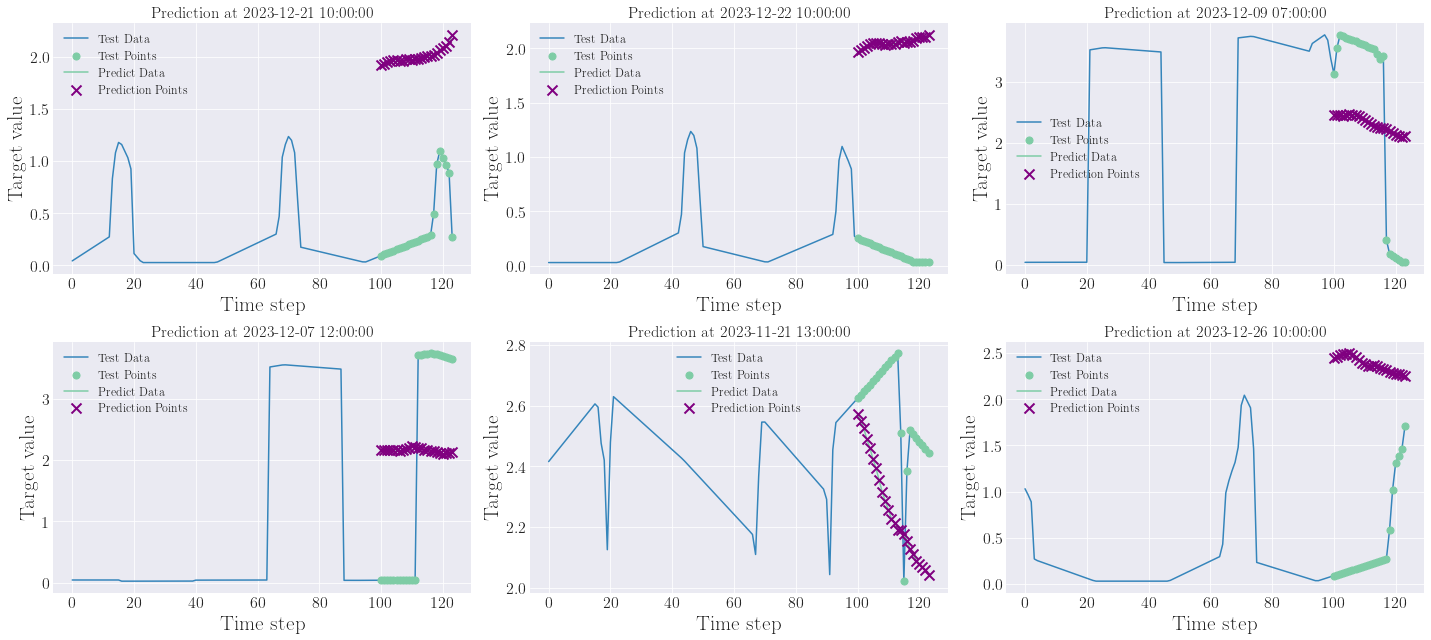